# Preprocessing file to understand 5G raw dataset

In [1]:
# General import and load data
import pandas as pd
import numpy as np

from pandas import Series, DataFrame

# Training and test spliting
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Text splitting
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split 

# Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

# NLP
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcdia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcdia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import raw dataset 5G

In [2]:
df_5G = pd.read_csv('dataset_5G_raw.csv')
df_5G.head()

,Unnamed: 0,id,Datetime,tweet,emotion
0,0,"1,25897E+18",2020-05-09 3:43:57,RT @skitvomfeinsten: +++++++ GOD AlWAYS WIN ++...,0.800000
1,1,1258470733879148547,2020-05-07 18:56:18,RT @HalladayIn: @outofcontroljb @kaitlancollin...,-0.090909
2,2,1258470843597889537,2020-05-07 18:56:45,RT @matthaig1: Hi conspiracy theorists! A few ...,-0.100000
3,3,1258470857325686785,2020-05-07 18:56:48,RT @panos941: People beginning to lose it 😬&gt...,-0.226852
4,4,1258470865286635522,2020-05-07 18:56:50,RT @ZaidZamanHamid: This is one of the most im...,0.450000


Aquí podemos ver el dataset y los valores de emociones sacados con TextBlob. A partir de aquí se estudiarán y visualizarán algunos aspectos del mismo.

## Estudio del resultado emociones

0.23699028259762356

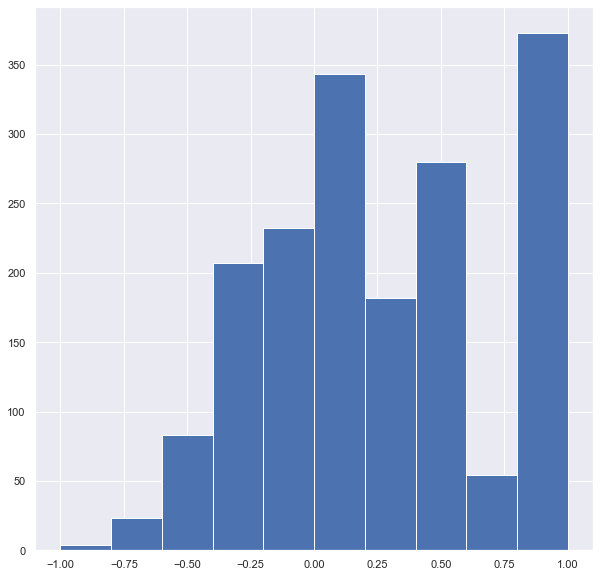

In [3]:
df_5G['emotion'].hist(figsize=(10,10))
df_5G['emotion'].mean()

Como se puede ver, la herramienta de TextBlob saca como resultado que los tweets son en su mayoría positivos (emotion >= 0) y además se puede apreciar también que hay muchos casos con valor cercano a 1.0 (tweets muy positivos) tal y como se aprecia en la celda de debajo:

## Estudio del resultado emociones

In [4]:
df_5G['emotion'].value_counts()

 0.800000    368
 0.450000    171
 0.500000     87
-0.200000     63
 0.100000     49
            ... 
-0.110606      1
-0.214286      1
 0.606667      1
 0.122222      1
-0.075000      1
Name: emotion, Length: 365, dtype: int64

In [5]:
# Checkeo tweet_text no es NaN para comprobación de que scaper ha funcionado bien
df_5G[df_5G.tweet.isna()]

,Unnamed: 0,id,Datetime,tweet,emotion


Parte de esta limpieza está basada en https://ourcodingclub.github.io/tutorials/topic-modelling-python/

#### Método auxiliar para buscar RTs y añadirlos como boolean a la columna

In [6]:
# Finding RTs
# make a new column to highlight retweets
df_5G['is_retweet'] = df_5G['tweet'].apply(lambda x: x[:2]=='RT')
df_5G['is_retweet'].sum() 
df_5G.head()

,Unnamed: 0,id,Datetime,tweet,emotion,is_retweet
0,0,"1,25897E+18",2020-05-09 3:43:57,RT @skitvomfeinsten: +++++++ GOD AlWAYS WIN ++...,0.800000,True
1,1,1258470733879148547,2020-05-07 18:56:18,RT @HalladayIn: @outofcontroljb @kaitlancollin...,-0.090909,True
2,2,1258470843597889537,2020-05-07 18:56:45,RT @matthaig1: Hi conspiracy theorists! A few ...,-0.100000,True
3,3,1258470857325686785,2020-05-07 18:56:48,RT @panos941: People beginning to lose it 😬&gt...,-0.226852,True
4,4,1258470865286635522,2020-05-07 18:56:50,RT @ZaidZamanHamid: This is one of the most im...,0.450000,True


#### Visualización tweets repetidos

Contador de tweets repetidos: Al usar el scraper de tweets por ID, cada RT es un tweet_ID distinto que contiene el mismo texto que el tweet del que se ha hecho RT. Es por ello por lo que aparece dentro del dataset el mismo tweet N veces debido a que tiene N-1 RTs.

In [7]:
# 10 most repeated tweets to check that different tweets_IDs are duplicated due to RT
df_5G.groupby(['tweet']).size().reset_index(name='counts')\
  .sort_values('counts', ascending=False).head(10)


,tweet,counts
706,RT @skitvomfeinsten: +++++++ GOD AlWAYS WIN ++...,366
629,RT @ZaidZamanHamid: This is one of the most im...,168
569,RT @JamesrossrJames: and for you imbeciles tha...,48
559,"RT @GOPoversight: .@RepRatcliffe: ""I view Chin...",30
603,RT @ResistMonsters: @DesignationSix Wow why wo...,20
625,RT @Thomas_Binder: Thread web⬆️⬇️\n\nThe most ...,16
611,RT @Shirastweet: Very much enjoyed this conver...,15
668,RT @kennygee_70: Christ embassy members have f...,15
640,RT @cameronwilson: what seems distinct about A...,13
554,RT @EmmieSerge: Made a freestyle verse for Cov...,13


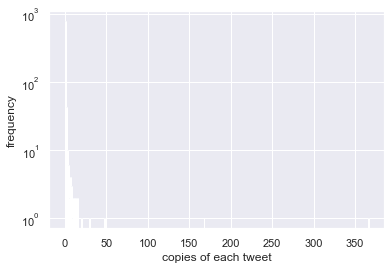

In [8]:
# Este fragmento de texto es para detectar cuántas veces se repiten los tweets más repetidos
# number of times each tweet appears
counts = df_5G.groupby(['tweet']).size()\
           .reset_index(name='counts')\
           .counts

# define bins for histogram
my_bins = np.arange(0,counts.max()+2, 1)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('copies of each tweet')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

#### Funciones auxiliares para buscar y añadir columnas extra

Estas nuevas columnas llevarán en un array el usuario que ha hecho RT, las meciones y los hashtags.

In [9]:
import re
# Creación de funciones auxiliares para buscar RTs, menciones y hashtags
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)   

In [10]:
# Crear nuevas columnas con las funciones anteriores
df_5G['retweeted'] = df_5G.tweet.apply(find_retweeted)
df_5G['mentioned'] = df_5G.tweet.apply(find_mentioned)
df_5G['hashtags'] = df_5G.tweet.apply(find_hashtags)

In [11]:
df_5G.head()

,Unnamed: 0,id,Datetime,tweet,emotion,is_retweet,retweeted,mentioned,hashtags
0,0,"1,25897E+18",2020-05-09 3:43:57,RT @skitvomfeinsten: +++++++ GOD AlWAYS WIN ++...,0.800000,True,[@skitvomfeinsten],[],"[#QAnon, #WWG1WGA, #WORLDWIDE, #Tower, #JE]"
1,1,1258470733879148547,2020-05-07 18:56:18,RT @HalladayIn: @outofcontroljb @kaitlancollin...,-0.090909,True,[@HalladayIn],"[@outofcontroljb, @kaitlancollins]",[]
2,2,1258470843597889537,2020-05-07 18:56:45,RT @matthaig1: Hi conspiracy theorists! A few ...,-0.100000,True,[@matthaig1],[],[]
3,3,1258470857325686785,2020-05-07 18:56:48,RT @panos941: People beginning to lose it 😬&gt...,-0.226852,True,[@panos941],[],[]
4,4,1258470865286635522,2020-05-07 18:56:50,RT @ZaidZamanHamid: This is one of the most im...,0.450000,True,[@ZaidZamanHamid],[],[#Covid_19]


#### Funciones auxiliares para borrar links y usuarios del texto del tweet

In [12]:
# Adición de varias columnas con texto sin links ni usuarios
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [13]:
df_5G['no_links'] = df_5G.tweet.apply(remove_links)
df_5G['no_users'] = df_5G.tweet.apply(remove_users)

In [14]:
df_5G.head()

,Unnamed: 0,id,Datetime,tweet,emotion,is_retweet,retweeted,mentioned,hashtags,no_links,no_users
0,0,"1,25897E+18",2020-05-09 3:43:57,RT @skitvomfeinsten: +++++++ GOD AlWAYS WIN ++...,0.800000,True,[@skitvomfeinsten],[],"[#QAnon, #WWG1WGA, #WORLDWIDE, #Tower, #JE]",RT @skitvomfeinsten: +++++++ GOD AlWAYS WIN ++...,: +++++++ GOD AlWAYS WIN +++++++\n\nBirds disc...
1,1,1258470733879148547,2020-05-07 18:56:18,RT @HalladayIn: @outofcontroljb @kaitlancollin...,-0.090909,True,[@HalladayIn],"[@outofcontroljb, @kaitlancollins]",[],RT @HalladayIn: @outofcontroljb @kaitlancollin...,: The Covid-positive valet is part of the de...
2,2,1258470843597889537,2020-05-07 18:56:45,RT @matthaig1: Hi conspiracy theorists! A few ...,-0.100000,True,[@matthaig1],[],[],RT @matthaig1: Hi conspiracy theorists! A few ...,: Hi conspiracy theorists! A few q’s. If 5G is...
3,3,1258470857325686785,2020-05-07 18:56:48,RT @panos941: People beginning to lose it 😬&gt...,-0.226852,True,[@panos941],[],[],RT @panos941: People beginning to lose it 😬&gt...,: People beginning to lose it 😬&gt;Almost 80 m...
4,4,1258470865286635522,2020-05-07 18:56:50,RT @ZaidZamanHamid: This is one of the most im...,0.450000,True,[@ZaidZamanHamid],[],[#Covid_19],RT @ZaidZamanHamid: This is one of the most im...,: This is one of the most important reasons wh...


Con este análisis se ha podido estudiar los posibles fallos y mejoras que se le pueden hacer al dataset descargado a partir del scraper. En el dataset común del equipo se aglutinarán con todas las contribuciones del equipo para generar un dataset limpio y listo para usarse